In [10]:
### already did regrid, so now open to reuse
import torch
import xesmf as xe
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.weight'] = "bold"
plt.rcParams['legend.framealpha'] = 0

import glob

In [13]:
import os
os.getcwd()

'/work/albertl_uri_edu/f2f_holistic/scripts'

In [16]:
# glob.glob('../data/GLDAS/raw/*.nc*')

In [23]:
L = sorted(glob.glob('../data/GLDAS/raw/*.nc*'))
L = L[30:]
M = sorted(glob.glob('../data/MODIS/*.nc'))
for idx,x in enumerate(L):
    print(x[35:41], M[idx][34:42])
    if idx == 3:
        break

200207 20020731
200208 20020831
200209 20020930
200210 20021031


In [26]:
# loc_up = 230
# loc_down = 430
# loc_left = 800
# loc_right = 1600
#yukon

loc_up = 400
loc_down = 600
loc_left = 1350
loc_right = 1950
#columbia




weights = xr.open_dataset('../data/bilinear_600x1440_2160x4320.nc')
vmin = 0
vmax = 1
cmap = mpl.colormaps['cividis']
patchsize = 100
unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))


def replace_nan(z,val):
    z = np.where(z==val,np.nan,z)
    return z

def foldit(x,og):
    x0 = x.reshape(-1,1,x.shape[2]*x.shape[3]).permute(1,2,0)
    fold = torch.nn.Fold(output_size=(og.shape[2],og.shape[3]),kernel_size=(patchsize,patchsize),stride=(patchsize,patchsize))
    return fold(x0)

def zscore(x):
    # x = x.numpy()
    # x = np.where((x>0) & (x<1000) == True,x,0)
    np_nanmean = np.nanmean(x)
    np_nanstd = np.nanstd(x)
    zscored = (x-np_nanmean)/np_nanstd
    zscored = np.where(np.isfinite(zscored) == False,0,zscored)
    return zscored

In [41]:
for idx,x in enumerate(L):

    if idx % 12 == 0:
        print(x[35:41])

    y = xr.open_dataset(x)
    x1 = xr.open_dataset(M[idx])
    Qs_GLDAS = y.Qs_acc
    Qsb_GLDAS = y.Qsb_acc
    sst = x1.sst
    
    if idx == 0:
        regrid = xe.Regridder(Qs_GLDAS,sst,method='bilinear',weights=weights)

    Qs_GLDAS_rg = regrid(Qs_GLDAS)
    Qsb_GLDAS_rg = regrid(Qsb_GLDAS)
    Qs = replace_nan(Qs_GLDAS_rg,0)
    Qsb = replace_nan(Qsb_GLDAS_rg,0)

    a1 = np.roll(Qs[0],1000)
    a2 = np.roll(Qsb[0],1000)
    a1_bool = np.where(np.isnan(a1) == True, 1, 0)
    a2_bool = np.where(np.isnan(a2) == True, 1, 0)
    a1_0 = np.where(np.isnan(a1) == True, 0, a1)
    a2_0 = np.where(np.isnan(a2) == True, 0, a2)
    a3_0 = a1_0 + a2_0   
    a3_bool = np.where((a1_bool == 0) | (a2_bool == 0),a3_0,np.nan)
    a1 = a1[loc_up:loc_down,loc_left:loc_right]
    a2 = a2[loc_up:loc_down,loc_left:loc_right]
    a2 = zscore(a2)
    a3 = a3_bool[loc_up:loc_down,loc_left:loc_right]
    a4 = np.roll(sst,1000)
    a4 = a4[loc_up:loc_down,loc_left:loc_right]
    a4 = zscore(a4)
    A4 = torch.from_numpy(a4).unsqueeze(0).unsqueeze(0)
    mask_patches = unfoldobj(A4).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
    d = [torch.where(torch.isfinite(x) == True, x, torch.nanmean(x)) for x in mask_patches]
    for idz,z in enumerate(d):
        if idz == 0:
            e = z
        else:
            e = torch.cat((e,z))
    e = e.unsqueeze(1)
    ya = foldit(e,A4)
    ya = np.where(np.isfinite(ya) == False, np.nanmean(ya),ya)

    xxxx = np.where(np.isfinite(a3) == True, a3, ya[0,0])
    np.save(f'../data/MOGL/MOGL_COL_ZSCORE/{x[35:41]}_COL_MOGL_ZSCORE.npy',xxxx)
    # break


# fig = plt.figure(figsize=(15,10))
# gs = gridspec.GridSpec(nrows=3,ncols=1,hspace=.05,wspace=.2,width_ratios=[1],height_ratios=[.3,.3,.4])
# sub0 = gs[0].subgridspec(1,2)
# sub1 = gs[1].subgridspec(1,2)

# fig.add_subplot(sub0[0])
# plt.imshow(a1,
#            vmin=vmin,
#            vmax=vmax,
#           cmap=cmap)
# plt.title('Qs')
# plt.colorbar(fraction=.01)

# fig.add_subplot(sub0[1])

# plt.imshow(a2,
#            vmin=vmin,
#            vmax=vmax,
#           cmap=cmap)
# plt.title('Qsb')
# plt.colorbar(fraction=.01)

# fig.add_subplot(sub1[0])
# plt.imshow(a3,
#            vmin=vmin,
#            vmax=vmax,
#           cmap=cmap)
# plt.title('Qs + Qsb where possible, \nnan or single value when not')
# plt.colorbar(fraction=.01)

# fig.add_subplot(sub1[1])
# plt.imshow(xxxx,cmap = cmap)
# plt.title('Qs + Qsb + SST, one colormap')
# plt.colorbar(fraction=.01)


# fig.add_subplot(gs[2])
# plt.imshow(np.where(np.isnan(a3) == False, a3,np.nan),cmap='turbo')
# plt.title('Qs + Qsb + SST, two colormaps')
# plt.gca().set_aspect('equal')
# clb = plt.colorbar(fraction=.015,location='right')
# clb.ax.set_title('kg m-2')
# plt.imshow(np.where(np.isnan(a3) == True, xxxx, np.nan),cmap='Greens')
# clb = plt.colorbar(fraction=.015,location='right')
# clb.ax.set_title('°C');

200207


/work/albertl_uri_edu/.conda/envs/f2f_2/lib/python3.10/site-packages/xarray/core/dataarray.py:853: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


200307
200407
200507
200607
200707
200807
200907
201007
201107
201207
201307
201407
201507
201607
201707
201807
201907
202007
202107
202207


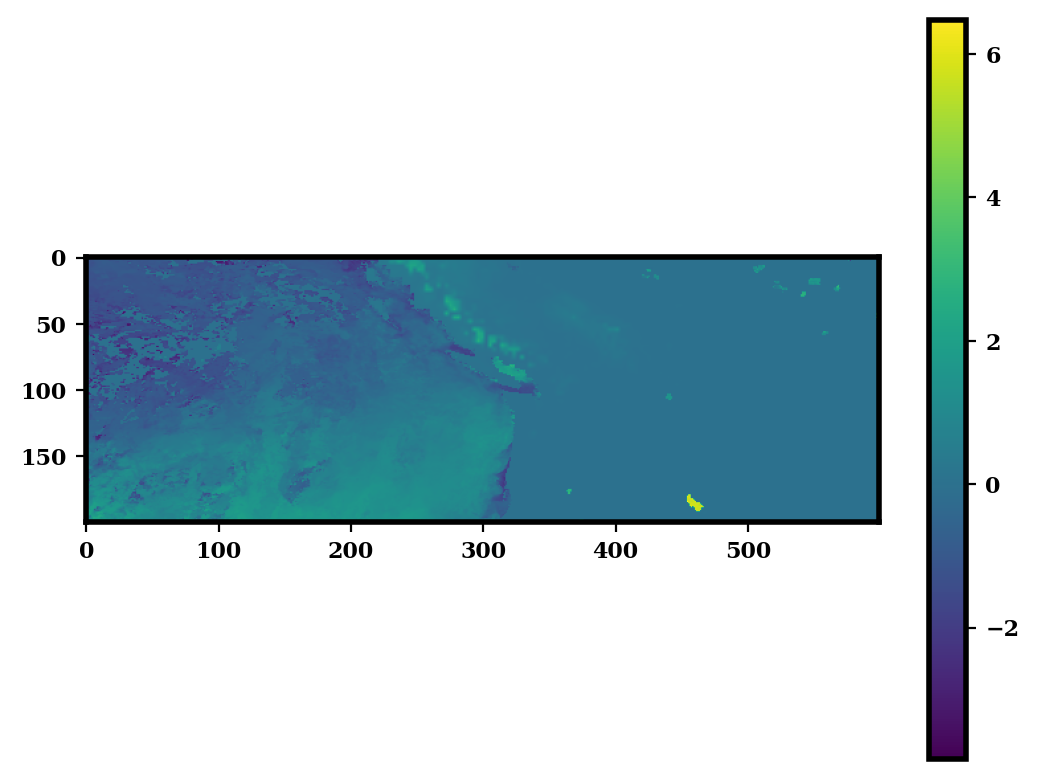

In [40]:
isee = np.load('../data/MOGL/MOGL_COL_ZSCORE/200207_COL_MOGL_ZSCORE.npy')
isee.shape

plt.imshow(isee)
plt.colorbar()

In [29]:
huh = glob.glob('../data/MOGL/*.npy')[0]
# os.rename(huh,

In [35]:
huh[:20] + 'YUK_' + huh[20:]

'../data/MOGL/200207_YUK_MOGL.npy'

In [37]:
import os
for x in glob.glob('../data/MOGL/*.npy'):
    os.rename(x,x[:20] + 'YUK_' + x[20:])

In [29]:
a4.shape

(2160, 4320)

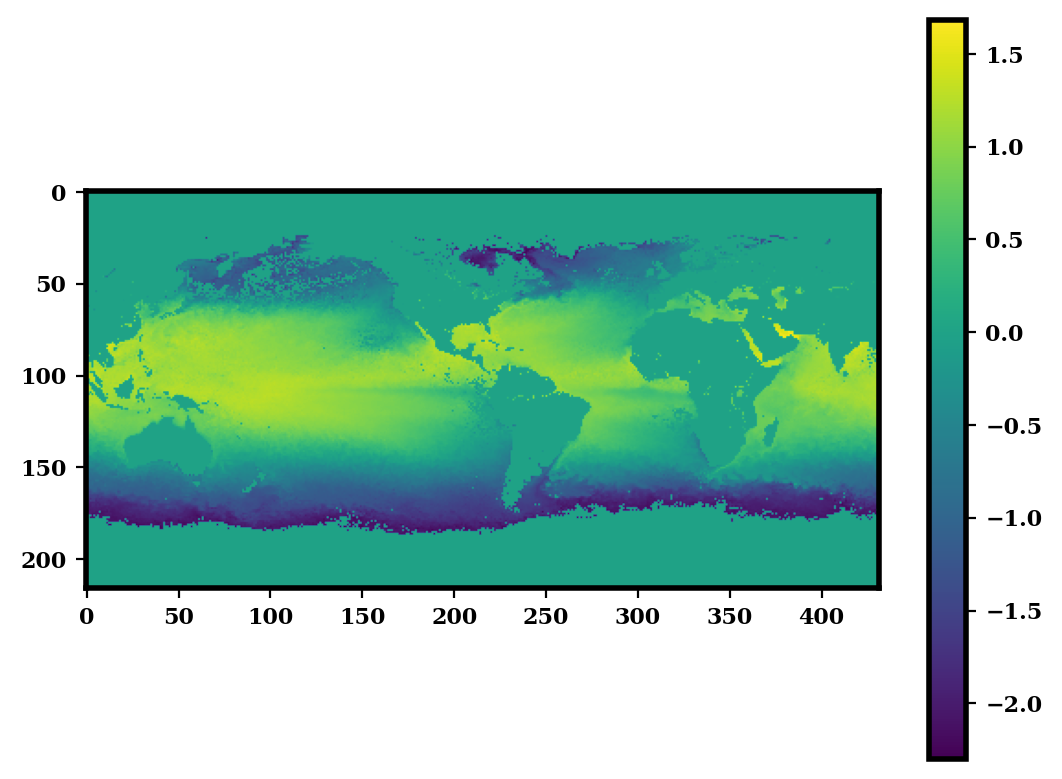

In [32]:
plt.imshow(a4[::10,::10])
plt.colorbar()

In [42]:
x0 = sorted(glob.glob('../data/MOGL/MOGL_COL_ZSCORE/*.npy'))

for idx, i in enumerate(x0):
    if idx == 0:
        print(i)
        y0 = torch.from_numpy(np.load(i)).unsqueeze(0)
    elif idx == 210:
        print(x0[idx-1])
        break
    else:
        y1 = torch.from_numpy(np.load(i)).unsqueeze(0)
        y0 = torch.cat((y0,y1))   
y0 = y0.unsqueeze(1)
print(y0.shape,'\n')
# torch.save(y0,'../data/traintest/COL_MOGL_ZSCORE_traintest.pt')


../data/MOGL/MOGL_COL_ZSCORE/200207_COL_MOGL_ZSCORE.npy
../data/MOGL/MOGL_COL_ZSCORE/201912_COL_MOGL_ZSCORE.npy
torch.Size([210, 1, 200, 600]) 



In [43]:
torch.save(y0,'../data/traintest/COL_MOGL_ZSCORE_traintest.pt')